Parsing VCF file: snp-only-10.vcf.recode.vcf.gz
Found 197 samples
Parsed 225204 variants
Loading sample metadata...
Found 18 populations: ['KO', 'WD', 'JB', 'SA', 'MI', 'Bhp', 'Ma', 'Bha', 'Ra', 'Mu', 'MO', 'Ja', 'Na', 'Brf', 'LA', 'AL', 'Od', 'Ga']
Calculating allele frequencies...
Processing population AL with 11 samples
Processing population Bha with 12 samples
Processing population Bhp with 12 samples
Processing population Brf with 12 samples
Processing population Ga with 12 samples
Processing population Ja with 12 samples
Processing population JB with 6 samples
Processing population KO with 12 samples
Processing population LA with 10 samples
Processing population Ma with 12 samples
Processing population MI with 11 samples
Processing population MO with 12 samples
Processing population Mu with 9 samples
Processing population Na with 12 samples
Processing population Od with 7 samples
Processing population Ra with 12 samples
Processing population SA with 11 samples
Processing populati

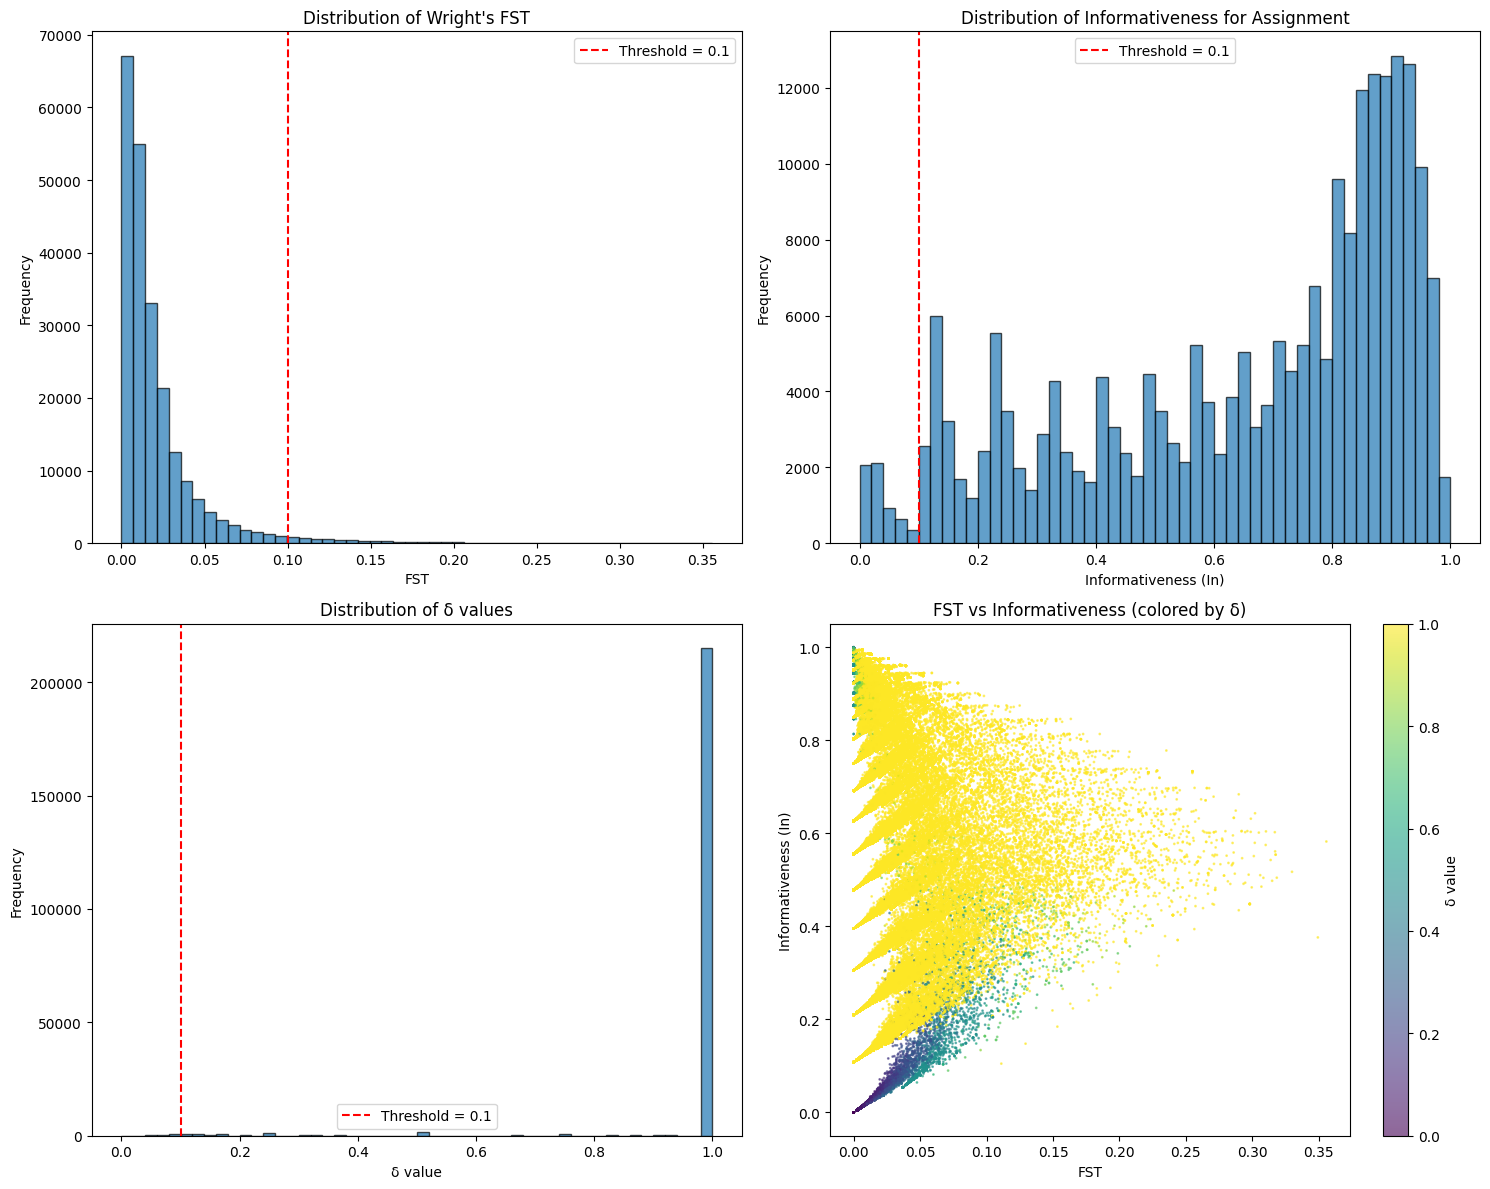


Saving results...
Saved all SNP statistics to: all_snp_statistics.csv
Saved FST informative SNPs to: fst_informative_snps.csv
Saved informativeness SNPs to: informativeness_snps.csv
Saved δ informative SNPs to: delta_informative_snps.csv
Saved common informative SNPs to: common_informative_snps.csv
Saved analysis summary to: analysis_summary.txt

Analysis completed successfully!


In [ ]:
#!/usr/bin/env python3
"""
SNP Informativeness Analysis - Minimal Dependencies Version
Calculates Wright's FST, Informativeness for Assignment (In), and δ values
for SNP markers from VCF file, similar to TRES software functionality.
Uses only standard Python libraries and common packages.
"""

import pandas as pd
import numpy as np
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Install required packages
!pip install pandas numpy matplotlib seaborn

class VCFParser:
    """Simple VCF parser for SNP data"""

    def __init__(self, vcf_file):
        self.vcf_file = vcf_file

    def parse_vcf(self):
        """Parse VCF file and return genotype data"""
        print(f"Parsing VCF file: {self.vcf_file}")

        variants = []
        genotypes = []
        samples = []

        # Determine if file is gzipped
        if self.vcf_file.endswith('.gz'):
            file_handle = gzip.open(self.vcf_file, 'rt')
        else:
            file_handle = open(self.vcf_file, 'r')

        with file_handle:
            for line in file_handle:
                if line.startswith('##'):
                    continue
                elif line.startswith('#CHROM'):
                    # Header line with sample names
                    headers = line.strip().split('\t')
                    samples = headers[9:]  # Sample names start from column 9
                    print(f"Found {len(samples)} samples")
                elif not line.startswith('#'):
                    # Variant line
                    fields = line.strip().split('\t')

                    chrom = fields[0]
                    pos = int(fields[1])
                    ref = fields[3]
                    alt = fields[4]

                    # Parse genotypes (assuming GT is first in FORMAT)
                    gt_data = []
                    for i in range(9, len(fields)):
                        gt = fields[i].split(':')[0]  # Get GT field
                        if gt in ['0/0', '0|0']:
                            gt_data.append([0, 0])  # Homozygous reference
                        elif gt in ['0/1', '1/0', '0|1', '1|0']:
                            gt_data.append([0, 1])  # Heterozygous
                        elif gt in ['1/1', '1|1']:
                            gt_data.append([1, 1])  # Homozygous alternate
                        else:
                            gt_data.append([np.nan, np.nan])  # Missing data

                    variants.append({
                        'chrom': chrom,
                        'pos': pos,
                        'ref': ref,
                        'alt': alt,
                        'variant_id': f"{chrom}:{pos}"
                    })

                    genotypes.append(gt_data)

        print(f"Parsed {len(variants)} variants")

        return {
            'variants': variants,
            'genotypes': np.array(genotypes),
            'samples': samples
        }

class SNPInformativenessAnalyzer:
    def __init__(self, vcf_file, sample_file):
        """
        Initialize the analyzer with VCF file and sample metadata

        Args:
            vcf_file: Path to VCF file (can be gzipped)
            sample_file: Path to TSV file with sample to population mapping
        """
        self.vcf_file = vcf_file
        self.sample_file = sample_file
        self.vcf_data = None
        self.samples = None
        self.populations = None
        self.pop_map = None

    def load_data(self):
        """Load VCF data and sample metadata"""
        # Parse VCF file
        parser = VCFParser(self.vcf_file)
        self.vcf_data = parser.parse_vcf()
        self.samples = self.vcf_data['samples']

        # Load sample to population mapping
        print("Loading sample metadata...")
        pop_df = pd.read_csv(self.sample_file, sep='\t', header=0)

        # Handle different possible column names
        if pop_df.shape[1] >= 2:
            if 'sample' in pop_df.columns.str.lower():
                sample_col = [col for col in pop_df.columns if 'sample' in col.lower()][0]
            else:
                sample_col = pop_df.columns[0]

            if 'pop' in pop_df.columns.str.lower() or 'race' in pop_df.columns.str.lower():
                pop_col = [col for col in pop_df.columns if 'pop' in col.lower() or 'race' in col.lower()][0]
            else:
                pop_col = pop_df.columns[1]

            self.pop_map = dict(zip(pop_df[sample_col], pop_df[pop_col]))
        else:
            raise ValueError("Sample file must have at least 2 columns")

        # Map samples to populations
        self.populations = [self.pop_map.get(sample, 'Unknown') for sample in self.samples]
        unique_pops = list(set([p for p in self.populations if p != 'Unknown']))
        print(f"Found {len(unique_pops)} populations: {unique_pops}")

        if len(unique_pops) < 2:
            raise ValueError("Need at least 2 populations for analysis")

    def calculate_allele_frequencies(self):
        """Calculate allele frequencies per population"""
        print("Calculating allele frequencies...")

        genotypes = self.vcf_data['genotypes']  # Shape: (n_variants, n_samples, 2)

        # Group samples by population
        pop_indices = defaultdict(list)
        for i, pop in enumerate(self.populations):
            if pop != 'Unknown':
                pop_indices[pop].append(i)

        # Calculate allele frequencies for each population
        pop_af = {}
        pop_counts = {}

        for pop, indices in pop_indices.items():
            print(f"Processing population {pop} with {len(indices)} samples")

            # Extract genotypes for this population
            pop_genotypes = genotypes[:, indices, :]  # (n_variants, n_pop_samples, 2)

            # Calculate allele frequencies for each variant
            af_list = []
            count_list = []

            for var_idx in range(len(genotypes)):
                var_genotypes = pop_genotypes[var_idx]  # (n_pop_samples, 2)

                # Count alleles (0 = ref, 1 = alt)
                valid_genotypes = var_genotypes[~np.isnan(var_genotypes).any(axis=1)]

                if len(valid_genotypes) > 0:
                    ref_count = np.sum(valid_genotypes == 0)
                    alt_count = np.sum(valid_genotypes == 1)
                    total = ref_count + alt_count

                    if total > 0:
                        ref_freq = ref_count / total
                        alt_freq = alt_count / total
                    else:
                        ref_freq = alt_freq = 0
                else:
                    ref_count = alt_count = 0
                    ref_freq = alt_freq = 0

                af_list.append([ref_freq, alt_freq])
                count_list.append([ref_count, alt_count])

            pop_af[pop] = np.array(af_list)
            pop_counts[pop] = np.array(count_list)

        return pop_af, pop_counts

    def calculate_fst(self, pop_af, pop_counts):
        """
        Calculate Wright's FST using Weir and Cockerham's method
        """
        print("Calculating Wright's FST...")

        pop_list = list(pop_af.keys())
        n_variants = len(pop_af[pop_list[0]])

        # Calculate mean FST across all population pairs
        fst_values = np.zeros(n_variants)
        pair_count = 0

        for i in range(len(pop_list)):
            for j in range(i + 1, len(pop_list)):
                pop1, pop2 = pop_list[i], pop_list[j]

                # Calculate FST for each variant between this population pair
                for var_idx in range(n_variants):
                    p1 = pop_af[pop1][var_idx, 1]  # Alt allele frequency in pop1
                    p2 = pop_af[pop2][var_idx, 1]  # Alt allele frequency in pop2

                    # Sample sizes
                    n1 = np.sum(pop_counts[pop1][var_idx])
                    n2 = np.sum(pop_counts[pop2][var_idx])

                    if n1 > 0 and n2 > 0:
                        # Mean frequency
                        p_mean = (p1 + p2) / 2

                        # Variance components (simplified)
                        if p_mean > 0 and p_mean < 1:
                            # Between population variance
                            var_between = ((p1 - p_mean)**2 + (p2 - p_mean)**2) / 2

                            # Total variance
                            var_total = p_mean * (1 - p_mean)

                            if var_total > 0:
                                fst_pair = var_between / var_total
                                fst_values[var_idx] += max(0, min(1, fst_pair))

                pair_count += 1

        # Average across all pairs
        if pair_count > 0:
            fst_values /= pair_count

        return fst_values

    def calculate_informativeness_assignment(self, pop_af):
        """
        Calculate Informativeness for Assignment (In) - Rosenberg et al. 2002
        In = 1 - Σ(pi²) where pi is the frequency of allele i across populations
        """
        print("Calculating Informativeness for Assignment (In)...")

        pop_list = list(pop_af.keys())
        n_variants = len(pop_af[pop_list[0]])

        informativeness = np.zeros(n_variants)

        for var_idx in range(n_variants):
            # Get allele frequencies across all populations
            ref_freqs = []
            alt_freqs = []

            for pop in pop_list:
                ref_freqs.append(pop_af[pop][var_idx, 0])
                alt_freqs.append(pop_af[pop][var_idx, 1])

            # Calculate mean frequency across populations
            mean_ref_freq = np.mean(ref_freqs)
            mean_alt_freq = np.mean(alt_freqs)

            # In = 1 - sum(p_i^2) for each allele i
            informativeness[var_idx] = 1 - (mean_ref_freq**2 + mean_alt_freq**2)

        return informativeness

    def calculate_delta(self, pop_af):
        """
        Calculate δ values (Shriver et al. 2003)
        δ = |p1 - p2| for the most informative allele between populations
        """
        print("Calculating δ values...")

        pop_list = list(pop_af.keys())
        n_variants = len(pop_af[pop_list[0]])

        delta_values = np.zeros(n_variants)

        for var_idx in range(n_variants):
            max_delta = 0

            # Compare all population pairs
            for i in range(len(pop_list)):
                for j in range(i + 1, len(pop_list)):
                    pop1, pop2 = pop_list[i], pop_list[j]

                    # Calculate delta for both alleles and take maximum
                    ref_delta = abs(pop_af[pop1][var_idx, 0] - pop_af[pop2][var_idx, 0])
                    alt_delta = abs(pop_af[pop1][var_idx, 1] - pop_af[pop2][var_idx, 1])

                    max_delta = max(max_delta, ref_delta, alt_delta)

            delta_values[var_idx] = max_delta

        return delta_values

    def create_results_dataframe(self, fst_values, informativeness, delta_values):
        """Create results DataFrame with all statistics"""

        variants = self.vcf_data['variants']

        results_df = pd.DataFrame({
            'variant_id': [v['variant_id'] for v in variants],
            'chromosome': [v['chrom'] for v in variants],
            'position': [v['pos'] for v in variants],
            'ref_allele': [v['ref'] for v in variants],
            'alt_allele': [v['alt'] for v in variants],
            'fst': fst_values,
            'informativeness': informativeness,
            'delta': delta_values
        })

        return results_df

    def filter_informative_snps(self, results_df, fst_threshold=0.1,
                               informativeness_threshold=0.1, delta_threshold=0.1):
        """Filter SNPs based on thresholds and find common informative SNPs"""

        print(f"\nApplying thresholds:")
        print(f"FST > {fst_threshold}")
        print(f"Informativeness > {informativeness_threshold}")
        print(f"δ > {delta_threshold}")

        # Filter by individual metrics
        fst_snps = results_df[results_df['fst'] > fst_threshold].copy()
        info_snps = results_df[results_df['informativeness'] > informativeness_threshold].copy()
        delta_snps = results_df[results_df['delta'] > delta_threshold].copy()

        # Find common SNPs across all three metrics
        common_snps = results_df[
            (results_df['fst'] > fst_threshold) &
            (results_df['informativeness'] > informativeness_threshold) &
            (results_df['delta'] > delta_threshold)
        ].copy()

        print(f"\nResults:")
        print(f"FST informative SNPs: {len(fst_snps)}")
        print(f"Informativeness SNPs: {len(info_snps)}")
        print(f"δ informative SNPs: {len(delta_snps)}")
        print(f"Common informative SNPs: {len(common_snps)}")

        return fst_snps, info_snps, delta_snps, common_snps

    def plot_results(self, results_df, fst_snps, info_snps, delta_snps, common_snps):
        """Create visualization plots"""

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Plot 1: Distribution of FST values
        axes[0,0].hist(results_df['fst'], bins=50, alpha=0.7, edgecolor='black')
        axes[0,0].axvline(x=0.1, color='red', linestyle='--', label='Threshold = 0.1')
        axes[0,0].set_xlabel('FST')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].set_title('Distribution of Wright\'s FST')
        axes[0,0].legend()

        # Plot 2: Distribution of Informativeness values
        axes[0,1].hist(results_df['informativeness'], bins=50, alpha=0.7, edgecolor='black')
        axes[0,1].axvline(x=0.1, color='red', linestyle='--', label='Threshold = 0.1')
        axes[0,1].set_xlabel('Informativeness (In)')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].set_title('Distribution of Informativeness for Assignment')
        axes[0,1].legend()

        # Plot 3: Distribution of δ values
        axes[1,0].hist(results_df['delta'], bins=50, alpha=0.7, edgecolor='black')
        axes[1,0].axvline(x=0.1, color='red', linestyle='--', label='Threshold = 0.1')
        axes[1,0].set_xlabel('δ value')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_title('Distribution of δ values')
        axes[1,0].legend()

        # Plot 4: Scatter plot of metrics
        scatter = axes[1,1].scatter(results_df['fst'], results_df['informativeness'],
                                  c=results_df['delta'], cmap='viridis', alpha=0.6, s=1)
        axes[1,1].set_xlabel('FST')
        axes[1,1].set_ylabel('Informativeness (In)')
        axes[1,1].set_title('FST vs Informativeness (colored by δ)')
        plt.colorbar(scatter, ax=axes[1,1], label='δ value')

        plt.tight_layout()
        plt.savefig('snp_informativeness_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

    def save_results(self, results_df, fst_snps, info_snps, delta_snps, common_snps):
        """Save results to files"""

        print("\nSaving results...")

        # Save all results
        results_df.to_csv('all_snp_statistics.csv', index=False)
        print(f"Saved all SNP statistics to: all_snp_statistics.csv")

        # Save informative SNPs by individual metrics
        fst_snps.to_csv('fst_informative_snps.csv', index=False)
        print(f"Saved FST informative SNPs to: fst_informative_snps.csv")

        info_snps.to_csv('informativeness_snps.csv', index=False)
        print(f"Saved informativeness SNPs to: informativeness_snps.csv")

        delta_snps.to_csv('delta_informative_snps.csv', index=False)
        print(f"Saved δ informative SNPs to: delta_informative_snps.csv")

        # Save common informative SNPs
        common_snps.to_csv('common_informative_snps.csv', index=False)
        print(f"Saved common informative SNPs to: common_informative_snps.csv")

        # Create summary report
        summary = f"""
SNP Informativeness Analysis Summary
====================================

Input files:
- VCF file: {self.vcf_file}
- Sample metadata: {self.sample_file}

Total variants analyzed: {len(results_df)}
Total samples: {len(self.samples)}
Populations: {list(set([p for p in self.populations if p != 'Unknown']))}

Thresholds applied:
- FST > 0.1
- Informativeness > 0.1
- δ > 0.1

Results:
- FST informative SNPs: {len(fst_snps)}
- Informativeness SNPs: {len(info_snps)}
- δ informative SNPs: {len(delta_snps)}
- Common informative SNPs (all three metrics): {len(common_snps)}

Statistics Summary:
- Mean FST: {results_df['fst'].mean():.4f}
- Mean Informativeness: {results_df['informativeness'].mean():.4f}
- Mean δ: {results_df['delta'].mean():.4f}

Top 10 most informative SNPs (by combined score):
"""

        # Calculate combined score
        results_df['combined_score'] = (results_df['fst'] +
                                      results_df['informativeness'] +
                                      results_df['delta']) / 3

        top_snps = results_df.nlargest(10, 'combined_score')[
            ['variant_id', 'fst', 'informativeness', 'delta', 'combined_score']
        ]

        summary += top_snps.to_string(index=False)

        with open('analysis_summary.txt', 'w') as f:
            f.write(summary)
        print("Saved analysis summary to: analysis_summary.txt")

def main():
    """Main analysis function"""

    # File paths - adjust these to your files
    vcf_file = 'snp-only-10.vcf.recode.vcf.gz'
    sample_file = 'sample_to_ecorace.tsv'

    try:
        # Initialize analyzer
        analyzer = SNPInformativenessAnalyzer(vcf_file, sample_file)

        # Load data
        analyzer.load_data()

        # Calculate allele frequencies
        pop_af, pop_counts = analyzer.calculate_allele_frequencies()

        # Calculate statistics
        fst_values = analyzer.calculate_fst(pop_af, pop_counts)
        informativeness = analyzer.calculate_informativeness_assignment(pop_af)
        delta_values = analyzer.calculate_delta(pop_af)

        # Create results DataFrame
        results_df = analyzer.create_results_dataframe(fst_values, informativeness, delta_values)

        # Filter informative SNPs (you can adjust these thresholds)
        fst_snps, info_snps, delta_snps, common_snps = analyzer.filter_informative_snps(
            results_df,
            fst_threshold=0.1,
            informativeness_threshold=0.1,
            delta_threshold=0.1
        )

        # Create plots
        analyzer.plot_results(results_df, fst_snps, info_snps, delta_snps, common_snps)

        # Save results
        analyzer.save_results(results_df, fst_snps, info_snps, delta_snps, common_snps)

        print("\nAnalysis completed successfully!")

        return results_df, common_snps

    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

# Run the analysis
if __name__ == "__main__":
    results_df, common_snps = main()

Running file loading test...
=== File Loading Test ===
VCF file exists: True
Sample file exists: True
SNP file exists: True

=== Sample File Content ===
Shape: (196, 2)
Columns: ['sorted-AL10.bam', 'AL']
First 5 rows:
   sorted-AL10.bam  AL
0  sorted-AL11.bam  AL
1  sorted-AL12.bam  AL
2   sorted-AL1.bam  AL
3   sorted-AL2.bam  AL
4   sorted-AL3.bam  AL

=== VCF File Test ===
Found 197 samples in VCF header
First 10 samples: ['sorted-AL10.bam', 'sorted-AL11.bam', 'sorted-AL12.bam', 'sorted-AL1.bam', 'sorted-AL2.bam', 'sorted-AL3.bam', 'sorted-AL4.bam', 'sorted-AL5.bam', 'sorted-AL6.bam', 'sorted-AL7.bam']

=== Running Simple Test ===
Testing VCF parsing...
Parsing VCF file: snp-only-10.vcf.recode.vcf.gz
Found 197 samples
Extracted genotype matrix: 197 samples × 225204 SNPs
Successfully parsed genotypes: (197, 225204)
Testing sample metadata loading...
Loading sample metadata...
Sample metadata shape: (196, 2)
Sample metadata columns: ['sorted-AL10.bam', 'AL']
First few rows:
   sorted-

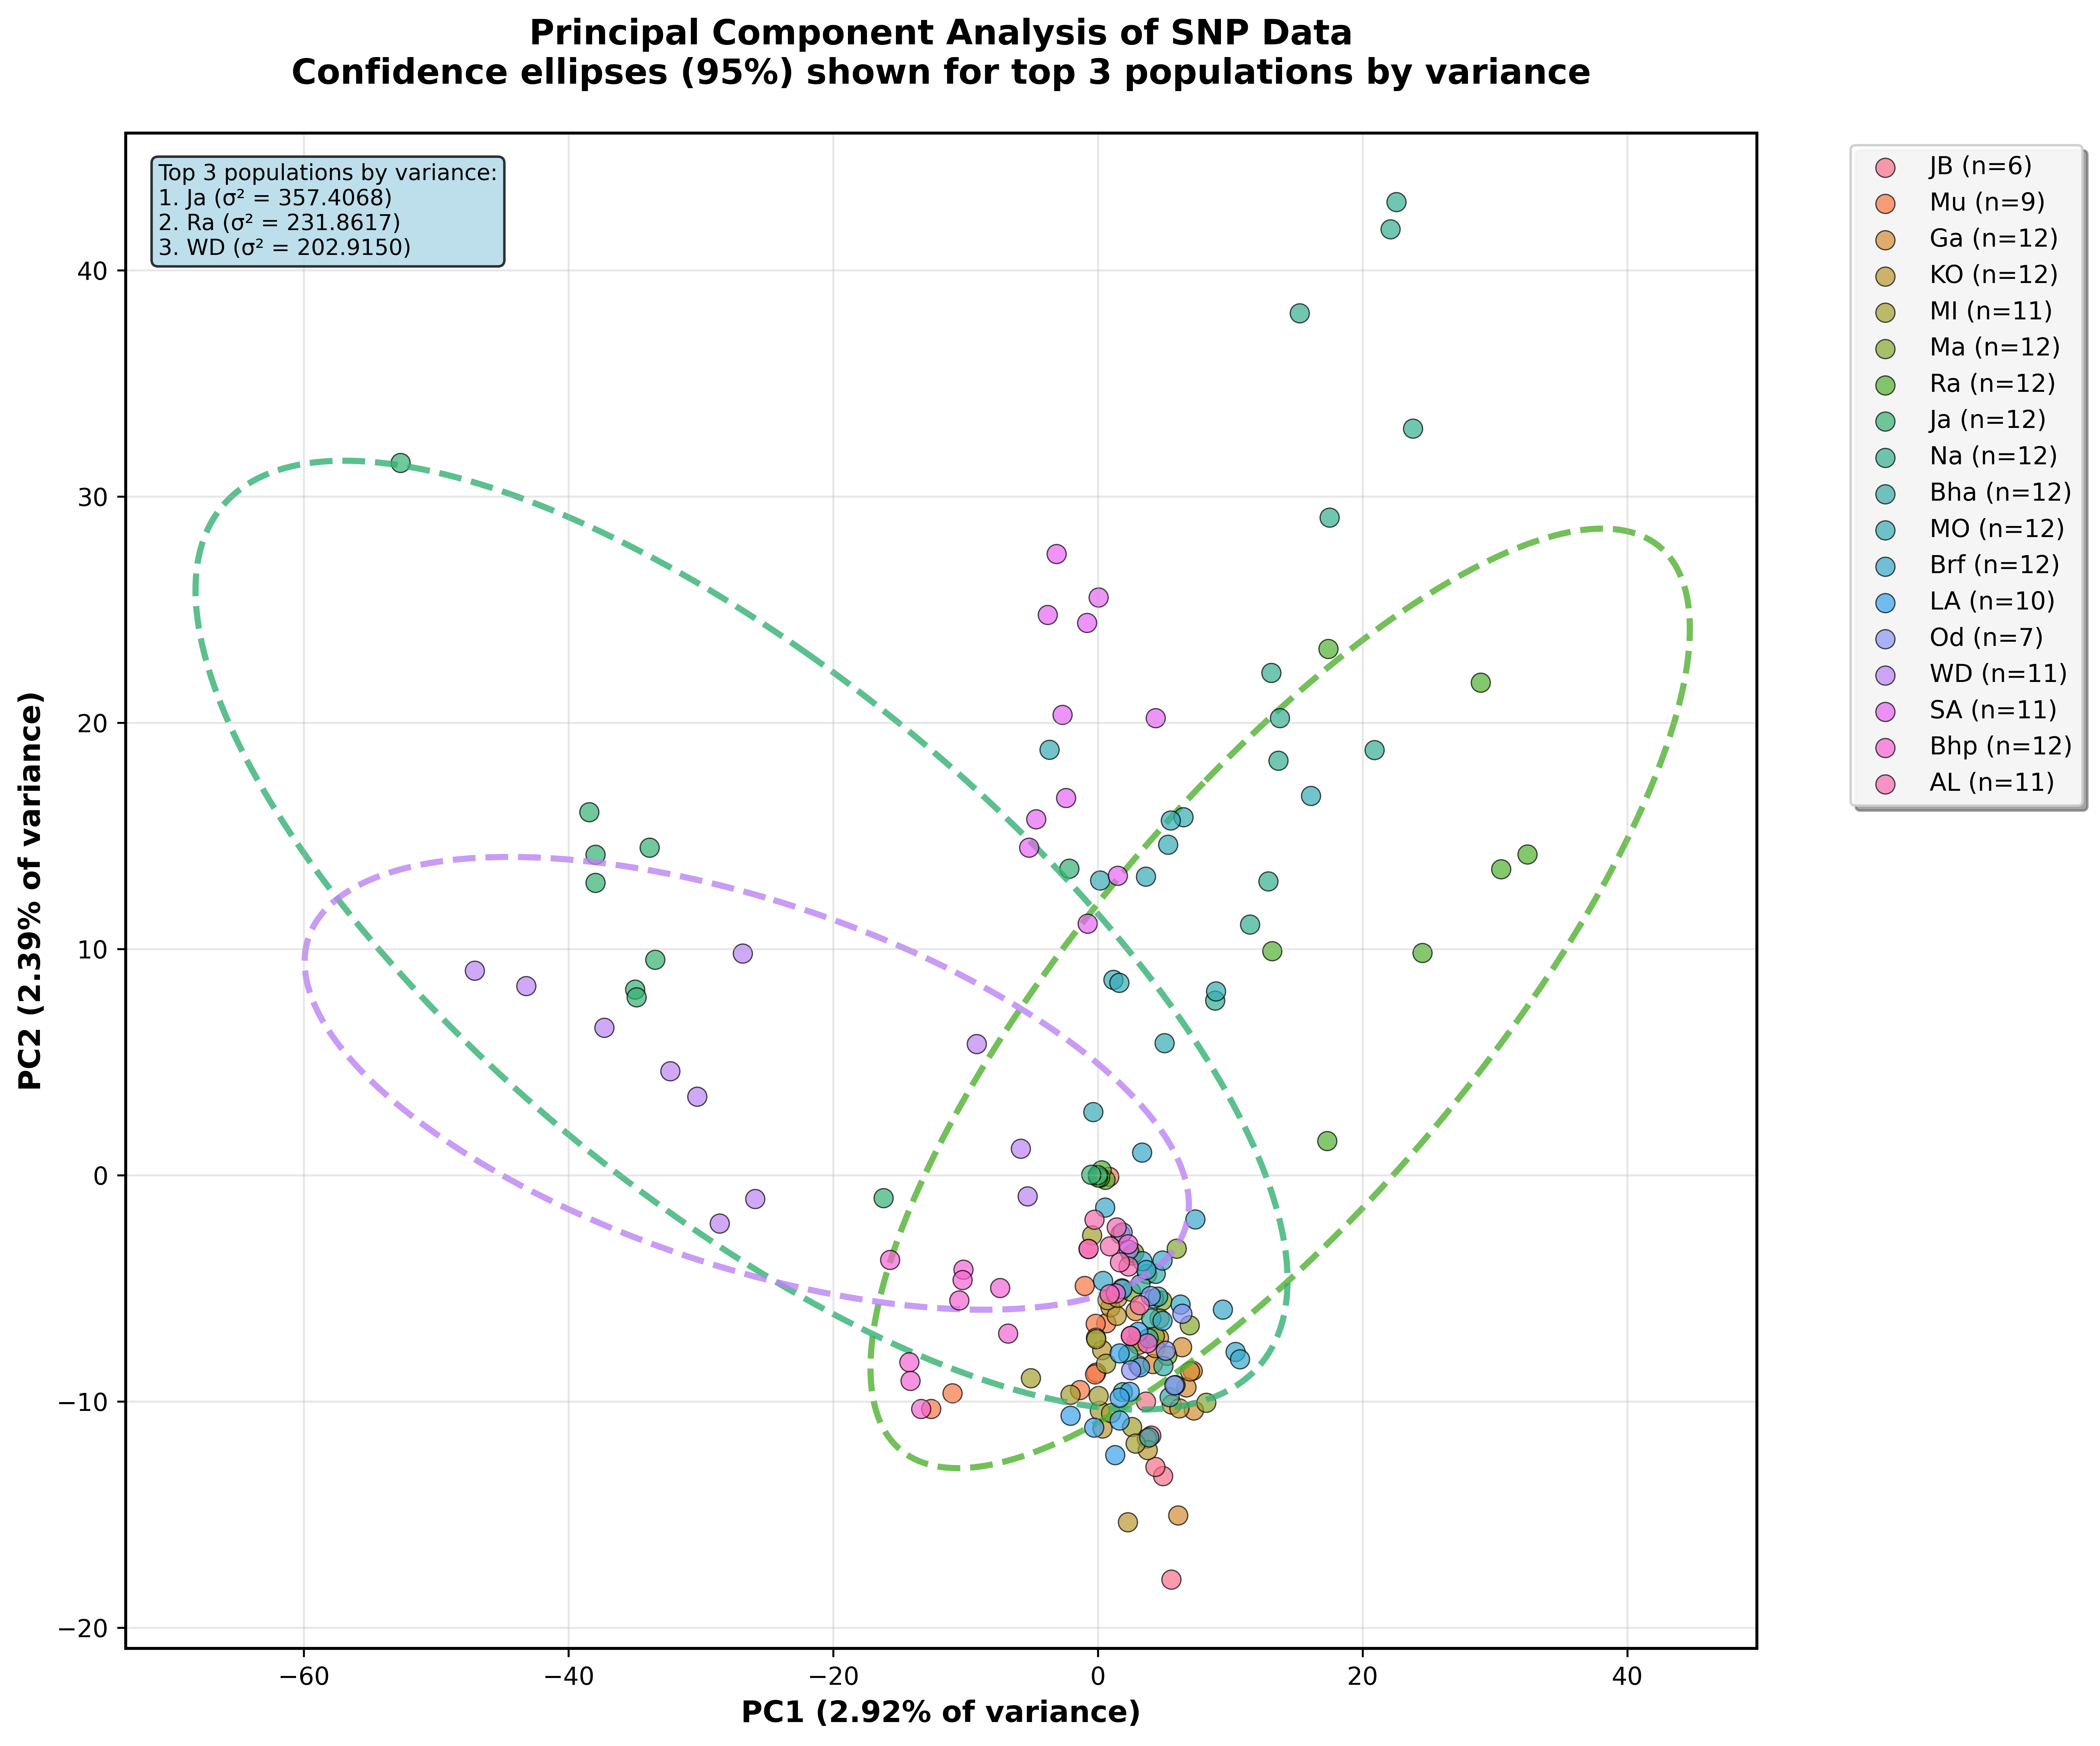

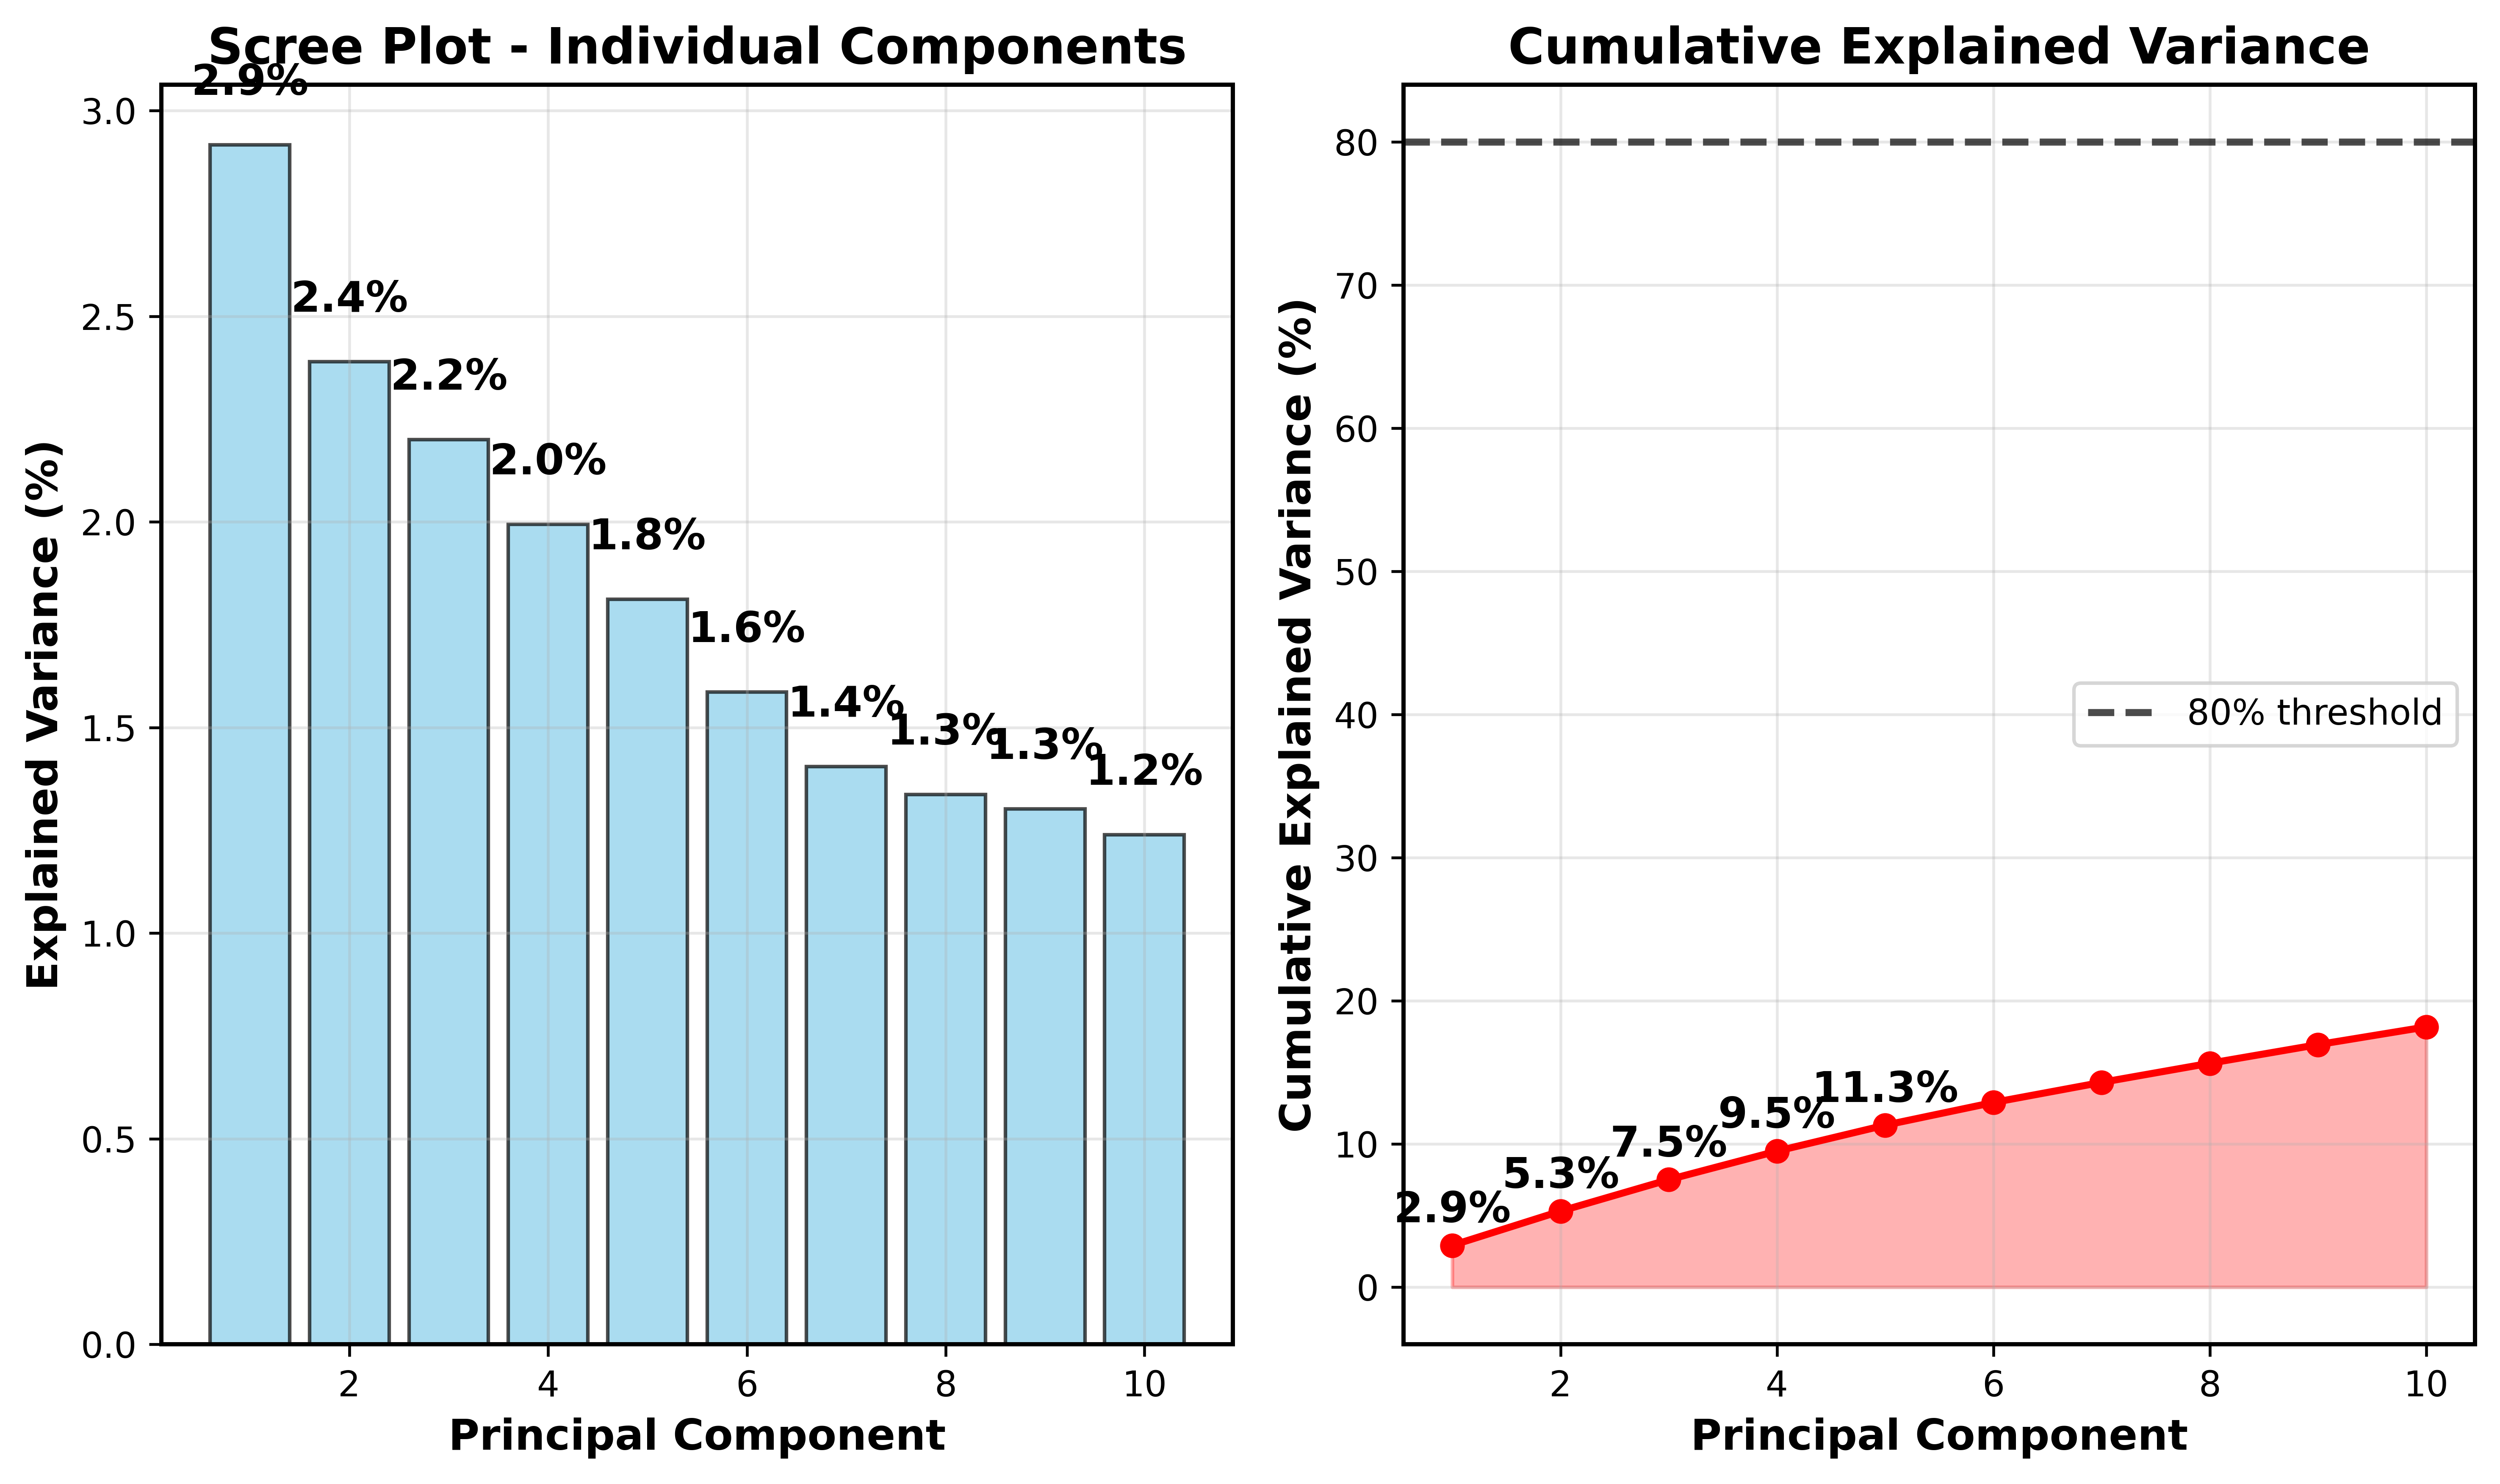

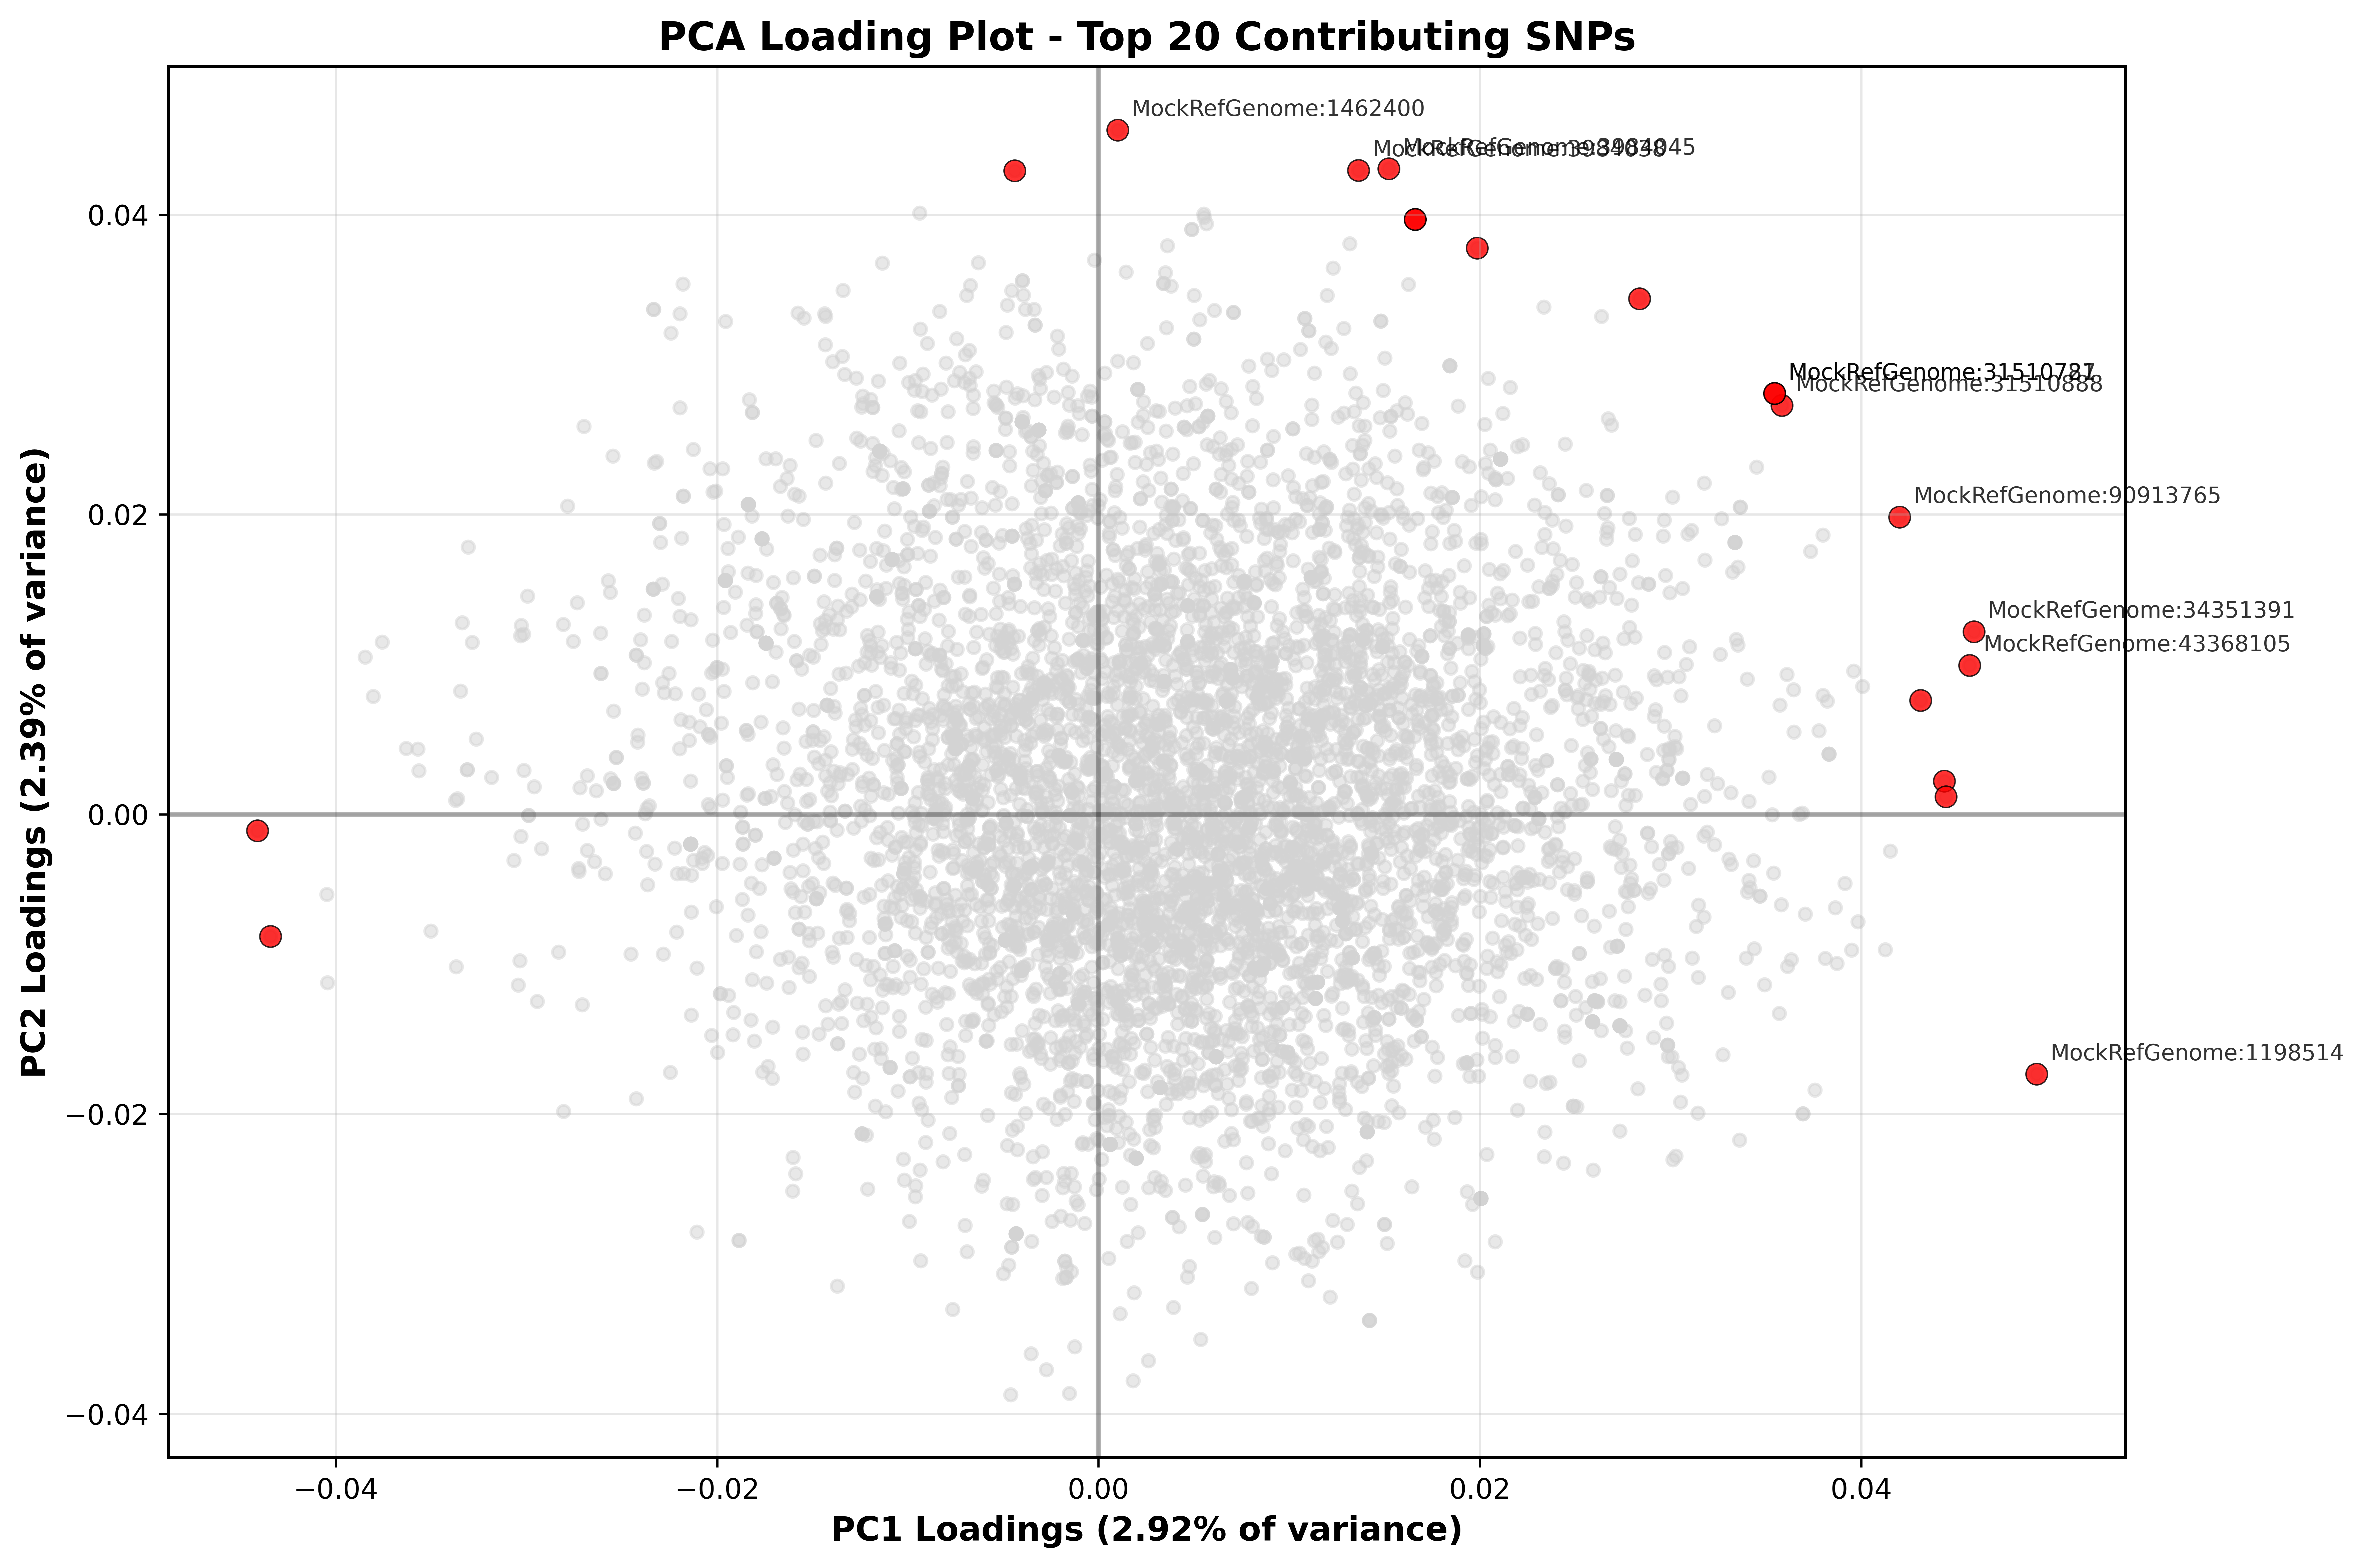


PCA analysis completed successfully!
Generated files:
  - pca_analysis_coordinates.csv (PCA coordinates for each sample)
  - pca_analysis_explained_variance.csv (Variance explained by each PC)
  - pca_analysis_pca_plot.png/pdf (Main PCA plot with confidence ellipses)
  - pca_analysis_scree_plot.png (Scree plot)
  - pca_analysis_loading_plot.png (SNP contribution plot)


In [ ]:
#!/usr/bin/env python3
"""
PCA Analysis and High-Quality Visualization
Performs PCA on SNP data and creates publication-quality plots with confidence ellipses
for the top 3 populations by variance at 600 DPI resolution.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance
import gzip
from collections import defaultdict
from matplotlib.patches import Ellipse
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn scipy

# Set high-quality plotting parameters
plt.rcParams.update({
    'figure.dpi': 600,
    'savefig.dpi': 600,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'font.family': 'DejaVu Sans',
    'axes.linewidth': 1.2,
    'grid.linewidth': 0.8,
    'lines.linewidth': 2.0,
    'patch.linewidth': 1.0
})

class PCAAnalyzer:
    def __init__(self, vcf_file=None, sample_file=None, snp_file=None):
        """
        Initialize PCA analyzer

        Args:
            vcf_file: Path to VCF file (optional if using pre-filtered SNPs)
            sample_file: Path to sample metadata file
            snp_file: Path to filtered SNPs file (optional, uses common_informative_snps.csv by default)
        """
        self.vcf_file = vcf_file
        self.sample_file = sample_file
        self.snp_file = snp_file or 'common_informative_snps.csv'
        self.genotype_matrix = None
        self.samples = None
        self.populations = None
        self.pop_map = None
        self.pca = None
        self.pca_result = None
        self.snp_positions = None

    def parse_vcf_genotypes(self, selected_positions=None):
        """Parse VCF file and extract genotype matrix for selected positions"""
        print(f"Parsing VCF file: {self.vcf_file}")

        genotypes_dict = {}
        samples = []

        # Determine if file is gzipped
        if self.vcf_file.endswith('.gz'):
            file_handle = gzip.open(self.vcf_file, 'rt')
        else:
            file_handle = open(self.vcf_file, 'r')

        with file_handle:
            for line in file_handle:
                if line.startswith('##'):
                    continue
                elif line.startswith('#CHROM'):
                    # Header line with sample names
                    headers = line.strip().split('\t')
                    samples = headers[9:]  # Sample names start from column 9
                    print(f"Found {len(samples)} samples")
                elif not line.startswith('#'):
                    # Variant line
                    fields = line.strip().split('\t')

                    chrom = fields[0]
                    pos = int(fields[1])
                    variant_id = f"{chrom}:{pos}"

                    # Skip if we have a selected list and this variant isn't in it
                    if selected_positions and variant_id not in selected_positions:
                        continue

                    # Parse genotypes
                    gt_data = []
                    for i in range(9, len(fields)):
                        gt = fields[i].split(':')[0]  # Get GT field

                        # Convert genotype to numeric (count of alt alleles)
                        if gt in ['0/0', '0|0']:
                            gt_data.append(0)  # Homozygous reference
                        elif gt in ['0/1', '1/0', '0|1', '1|0']:
                            gt_data.append(1)  # Heterozygous
                        elif gt in ['1/1', '1|1']:
                            gt_data.append(2)  # Homozygous alternate
                        else:
                            gt_data.append(np.nan)  # Missing data

                    genotypes_dict[variant_id] = gt_data

        self.samples = samples

        # Convert to matrix format
        if selected_positions:
            # Maintain order of selected positions
            ordered_variants = [pos for pos in selected_positions if pos in genotypes_dict]
        else:
            ordered_variants = list(genotypes_dict.keys())

        genotype_matrix = np.array([genotypes_dict[var] for var in ordered_variants]).T
        self.snp_positions = ordered_variants

        print(f"Extracted genotype matrix: {genotype_matrix.shape[0]} samples × {genotype_matrix.shape[1]} SNPs")

        return genotype_matrix

    def load_sample_metadata(self):
        """Load sample to population mapping"""
        print("Loading sample metadata...")

        # Check if samples are loaded
        if self.samples is None:
            raise ValueError("Samples not loaded. Please parse VCF file first.")

        if not os.path.exists(self.sample_file):
            raise FileNotFoundError(f"Sample file not found: {self.sample_file}")

        pop_df = pd.read_csv(self.sample_file, sep='\t', header=0)
        print(f"Sample metadata shape: {pop_df.shape}")
        print(f"Sample metadata columns: {list(pop_df.columns)}")
        print(f"First few rows:\n{pop_df.head()}")

        # Handle different possible column names
        if pop_df.shape[1] >= 2:
            if 'sample' in pop_df.columns.str.lower():
                sample_col = [col for col in pop_df.columns if 'sample' in col.lower()][0]
            else:
                sample_col = pop_df.columns[0]

            if 'pop' in pop_df.columns.str.lower() or 'race' in pop_df.columns.str.lower():
                pop_col = [col for col in pop_df.columns if 'pop' in col.lower() or 'race' in col.lower()][0]
            else:
                pop_col = pop_df.columns[1]

            print(f"Using sample column: {sample_col}")
            print(f"Using population column: {pop_col}")

            self.pop_map = dict(zip(pop_df[sample_col], pop_df[pop_col]))
        else:
            raise ValueError("Sample file must have at least 2 columns")

        # Map samples to populations
        print(f"Mapping {len(self.samples)} samples to populations...")
        self.populations = [self.pop_map.get(sample, 'Unknown') for sample in self.samples]
        unique_pops = [p for p in set(self.populations) if p != 'Unknown']
        print(f"Found {len(unique_pops)} populations: {unique_pops}")

        # Show population distribution
        pop_counts = {}
        for pop in self.populations:
            pop_counts[pop] = pop_counts.get(pop, 0) + 1
        print("Population distribution:")
        for pop, count in pop_counts.items():
            print(f"  {pop}: {count} samples")

    def load_informative_snps(self):
        """Load pre-filtered informative SNPs"""
        if not os.path.exists(self.snp_file):
            print(f"SNP file {self.snp_file} not found. Using all SNPs from VCF.")
            return None

        print(f"Loading informative SNPs from: {self.snp_file}")
        snp_df = pd.read_csv(self.snp_file)

        if 'variant_id' in snp_df.columns:
            selected_snps = set(snp_df['variant_id'].tolist())
        else:
            # Try to construct variant IDs from chromosome and position
            if 'chromosome' in snp_df.columns and 'position' in snp_df.columns:
                selected_snps = set([f"{row['chromosome']}:{row['position']}"
                                   for _, row in snp_df.iterrows()])
            else:
                print("Could not identify variant positions in SNP file.")
                return None

        print(f"Found {len(selected_snps)} informative SNPs to use for PCA")
        return selected_snps

    def perform_pca(self, n_components=10, use_informative_snps=True):
        """
        Perform PCA analysis on genotype data

        Args:
            n_components: Number of PCA components to compute
            use_informative_snps: Whether to use pre-filtered informative SNPs
        """
        print("Performing PCA analysis...")

        # Load SNP selection if requested
        selected_snps = None
        if use_informative_snps:
            selected_snps = self.load_informative_snps()

        # Parse genotypes (this will load samples)
        print("Loading genotype data...")
        self.genotype_matrix = self.parse_vcf_genotypes(selected_snps)

        # Now load sample metadata (samples are loaded from VCF parsing)
        self.load_sample_metadata()

        # Validate data
        if self.genotype_matrix is None:
            raise ValueError("Failed to load genotype matrix")

        if len(self.samples) != self.genotype_matrix.shape[0]:
            raise ValueError(f"Sample count mismatch: {len(self.samples)} samples vs {self.genotype_matrix.shape[0]} genotype rows")

        print(f"Genotype matrix shape: {self.genotype_matrix.shape}")
        print(f"Number of samples: {len(self.samples)}")
        print(f"Number of SNPs: {self.genotype_matrix.shape[1]}")

        # Handle missing data by imputing with mean
        print("Handling missing data...")
        missing_count = np.sum(np.isnan(self.genotype_matrix))
        total_count = self.genotype_matrix.size
        print(f"Missing data: {missing_count}/{total_count} ({missing_count/total_count*100:.2f}%)")

        for col in range(self.genotype_matrix.shape[1]):
            col_data = self.genotype_matrix[:, col]
            mask = ~np.isnan(col_data)
            if np.any(mask):
                mean_val = np.mean(col_data[mask])
                self.genotype_matrix[~mask, col] = mean_val
            else:
                self.genotype_matrix[:, col] = 1.0  # Default to heterozygous if all missing

        # Check for constant columns (no variation)
        print("Checking for invariant SNPs...")
        var_per_snp = np.var(self.genotype_matrix, axis=0)
        invariant_snps = np.sum(var_per_snp == 0)
        if invariant_snps > 0:
            print(f"Removing {invariant_snps} invariant SNPs...")
            variant_mask = var_per_snp > 0
            self.genotype_matrix = self.genotype_matrix[:, variant_mask]
            if self.snp_positions:
                self.snp_positions = [pos for i, pos in enumerate(self.snp_positions) if variant_mask[i]]

        print(f"Final genotype matrix shape: {self.genotype_matrix.shape}")

        # Standardize the data
        print("Standardizing genotype data...")
        scaler = StandardScaler()
        genotype_scaled = scaler.fit_transform(self.genotype_matrix)

        # Perform PCA
        print(f"Computing PCA with {n_components} components...")
        self.pca = PCA(n_components=min(n_components, self.genotype_matrix.shape[1], self.genotype_matrix.shape[0]))
        self.pca_result = self.pca.fit_transform(genotype_scaled)

        # Print explained variance
        print("\nPCA Results:")
        print("Explained variance ratio:")
        for i, var_ratio in enumerate(self.pca.explained_variance_ratio_[:5]):
            print(f"  PC{i+1}: {var_ratio:.4f} ({var_ratio*100:.2f}%)")

        cumulative_var = np.cumsum(self.pca.explained_variance_ratio_)
        print(f"Cumulative variance explained by first {min(5, len(cumulative_var))} PCs: {cumulative_var[min(4, len(cumulative_var)-1)]:.4f} ({cumulative_var[min(4, len(cumulative_var)-1)]*100:.2f}%)")

    def calculate_population_variance(self):
        """Calculate variance for each population to identify top 3"""
        print("Calculating population variances...")

        pop_variances = {}
        unique_pops = [p for p in set(self.populations) if p != 'Unknown']

        for pop in unique_pops:
            pop_indices = [i for i, p in enumerate(self.populations) if p == pop]
            if len(pop_indices) > 1:  # Need at least 2 samples to calculate variance
                pop_pca_data = self.pca_result[pop_indices, :2]  # Use first 2 PCs
                # Calculate total variance across PC1 and PC2
                total_var = np.var(pop_pca_data[:, 0]) + np.var(pop_pca_data[:, 1])
                pop_variances[pop] = total_var
                print(f"  {pop}: {total_var:.6f} (n={len(pop_indices)})")

        # Get top 3 populations by variance
        top_3_pops = sorted(pop_variances.items(), key=lambda x: x[1], reverse=True)[:3]
        top_3_pop_names = [pop for pop, var in top_3_pops]

        print(f"\nTop 3 populations by variance:")
        for i, (pop, var) in enumerate(top_3_pops):
            print(f"  {i+1}. {pop}: {var:.6f}")

        return top_3_pop_names, pop_variances

    def calculate_confidence_ellipse(self, x, y, confidence=0.95):
        """
        Calculate confidence ellipse parameters

        Args:
            x, y: Data points
            confidence: Confidence level (default 0.95 for 95%)

        Returns:
            Ellipse parameters (center, width, height, angle)
        """
        if len(x) < 2:
            return None

        # Calculate covariance matrix
        data = np.column_stack([x, y])
        cov = EmpiricalCovariance().fit(data)

        # Get center point
        center = np.mean(data, axis=0)

        # Get eigenvalues and eigenvectors
        eigenvals, eigenvecs = np.linalg.eigh(cov.covariance_)

        # Calculate ellipse parameters
        # Chi-square critical value for confidence level
        chi2_val = stats.chi2.ppf(confidence, df=2)

        # Width and height are 2 * sqrt(eigenvalue * chi2_critical)
        width = 2 * np.sqrt(eigenvals[1] * chi2_val)
        height = 2 * np.sqrt(eigenvals[0] * chi2_val)

        # Angle of rotation
        angle = np.degrees(np.arctan2(eigenvecs[1, 1], eigenvecs[1, 0]))

        return center, width, height, angle

    def create_pca_plot(self, figsize=(12, 10), confidence=0.95):
        """
        Create high-quality PCA plot with confidence ellipses

        Args:
            figsize: Figure size tuple
            confidence: Confidence level for ellipses
        """
        print(f"Creating PCA plot with {confidence*100}% confidence ellipses...")

        # Get top 3 populations by variance
        top_3_pops, all_variances = self.calculate_population_variance()

        # Create color palette
        unique_pops = [p for p in set(self.populations) if p != 'Unknown']
        n_pops = len(unique_pops)

        # Use a high-quality color palette
        if n_pops <= 10:
            colors = sns.color_palette("tab10", n_pops)
        else:
            colors = sns.color_palette("husl", n_pops)

        pop_colors = dict(zip(unique_pops, colors))

        # Create figure and axis
        fig, ax = plt.subplots(1, 1, figsize=figsize)

        # Plot points for each population
        plotted_pops = []
        for pop in unique_pops:
            pop_indices = [i for i, p in enumerate(self.populations) if p == pop]
            if len(pop_indices) > 0:
                x = self.pca_result[pop_indices, 0]
                y = self.pca_result[pop_indices, 1]

                # Plot points
                scatter = ax.scatter(x, y, c=[pop_colors[pop]],
                                   label=f'{pop} (n={len(pop_indices)})',
                                   alpha=0.7, s=60, edgecolors='black',
                                   linewidth=0.5)
                plotted_pops.append(pop)

                # Add confidence ellipse for top 3 populations
                if pop in top_3_pops and len(pop_indices) > 2:
                    ellipse_params = self.calculate_confidence_ellipse(x, y, confidence)
                    if ellipse_params:
                        center, width, height, angle = ellipse_params

                        ellipse = Ellipse(center, width, height, angle=angle,
                                        facecolor='none',
                                        edgecolor=pop_colors[pop],
                                        linewidth=2.5,
                                        linestyle='--',
                                        alpha=0.8)
                        ax.add_patch(ellipse)

        # Customize plot
        explained_var_1 = self.pca.explained_variance_ratio_[0] * 100
        explained_var_2 = self.pca.explained_variance_ratio_[1] * 100

        ax.set_xlabel(f'PC1 ({explained_var_1:.2f}% of variance)', fontweight='bold')
        ax.set_ylabel(f'PC2 ({explained_var_2:.2f}% of variance)', fontweight='bold')
        ax.set_title('Principal Component Analysis of SNP Data\n' +
                    f'Confidence ellipses ({confidence*100:.0f}%) shown for top 3 populations by variance',
                    fontweight='bold', pad=20)

        # Add grid
        ax.grid(True, alpha=0.3, linewidth=0.8)

        # Customize legend
        legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                          frameon=True, fancybox=True, shadow=True)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.9)

        # Add annotation for top 3 populations
        textstr = f'Top 3 populations by variance:\n'
        for i, pop in enumerate(top_3_pops):
            textstr += f'{i+1}. {pop} (σ² = {all_variances[pop]:.4f})\n'

        props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
        ax.text(0.02, 0.98, textstr.strip(), transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=props)

        # Adjust layout to prevent legend cutoff
        plt.tight_layout()

        return fig, ax

    def create_scree_plot(self, figsize=(10, 6)):
        """Create scree plot showing explained variance"""
        print("Creating scree plot...")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Plot 1: Explained variance ratio
        pcs = range(1, len(self.pca.explained_variance_ratio_) + 1)
        explained_var = self.pca.explained_variance_ratio_ * 100

        ax1.bar(pcs, explained_var, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.set_xlabel('Principal Component', fontweight='bold')
        ax1.set_ylabel('Explained Variance (%)', fontweight='bold')
        ax1.set_title('Scree Plot - Individual Components', fontweight='bold')
        ax1.grid(True, alpha=0.3)

        # Add value labels on bars
        for i, v in enumerate(explained_var):
            ax1.text(i + 1, v + 0.1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

        # Plot 2: Cumulative explained variance
        cumulative_var = np.cumsum(explained_var)
        ax2.plot(pcs, cumulative_var, 'o-', linewidth=2, markersize=6, color='red')
        ax2.fill_between(pcs, cumulative_var, alpha=0.3, color='red')
        ax2.set_xlabel('Principal Component', fontweight='bold')
        ax2.set_ylabel('Cumulative Explained Variance (%)', fontweight='bold')
        ax2.set_title('Cumulative Explained Variance', fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=80, color='black', linestyle='--', alpha=0.7, label='80% threshold')
        ax2.legend()

        # Add value labels
        for i, v in enumerate(cumulative_var[:5]):  # Label first 5 points
            ax2.text(i + 1, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        return fig

    def create_loading_plot(self, pc1=1, pc2=2, top_n=20, figsize=(12, 8)):
        """
        Create loading plot showing SNP contributions to PCs

        Args:
            pc1, pc2: Which PCs to plot (1-indexed)
            top_n: Number of top contributing SNPs to highlight
        """
        print(f"Creating loading plot for PC{pc1} vs PC{pc2}...")

        if not self.snp_positions or len(self.snp_positions) == 0:
            print("No SNP position information available for loading plot.")
            return None

        # Get loadings (components) for specified PCs
        pc1_idx = pc1 - 1
        pc2_idx = pc2 - 1

        loadings_pc1 = self.pca.components_[pc1_idx, :]
        loadings_pc2 = self.pca.components_[pc2_idx, :]

        # Calculate magnitude of loadings
        loading_magnitude = np.sqrt(loadings_pc1**2 + loadings_pc2**2)

        # Get top contributing SNPs
        top_indices = np.argsort(loading_magnitude)[-top_n:]

        fig, ax = plt.subplots(1, 1, figsize=figsize)

        # Plot all loadings
        ax.scatter(loadings_pc1, loadings_pc2, alpha=0.5, s=20, color='lightgray')

        # Highlight top contributing SNPs
        ax.scatter(loadings_pc1[top_indices], loadings_pc2[top_indices],
                  alpha=0.8, s=60, color='red', edgecolors='black', linewidth=0.5)

        # Add labels for top SNPs
        for idx in top_indices[-10:]:  # Label top 10
            ax.annotate(self.snp_positions[idx],
                       (loadings_pc1[idx], loadings_pc2[idx]),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.8)

        # Customize plot
        explained_var_1 = self.pca.explained_variance_ratio_[pc1_idx] * 100
        explained_var_2 = self.pca.explained_variance_ratio_[pc2_idx] * 100

        ax.set_xlabel(f'PC{pc1} Loadings ({explained_var_1:.2f}% of variance)', fontweight='bold')
        ax.set_ylabel(f'PC{pc2} Loadings ({explained_var_2:.2f}% of variance)', fontweight='bold')
        ax.set_title(f'PCA Loading Plot - Top {top_n} Contributing SNPs', fontweight='bold')

        # Add grid and center lines
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)

        plt.tight_layout()
        return fig

    def save_results(self, output_prefix='pca_analysis'):
        """Save PCA results and plots"""
        print("Saving PCA results...")

        # Save PCA coordinates
        pca_df = pd.DataFrame(self.pca_result, columns=[f'PC{i+1}' for i in range(self.pca_result.shape[1])])
        pca_df['sample'] = self.samples
        pca_df['population'] = self.populations

        pca_df.to_csv(f'{output_prefix}_coordinates.csv', index=False)
        print(f"Saved PCA coordinates to: {output_prefix}_coordinates.csv")

        # Save explained variance
        var_df = pd.DataFrame({
            'PC': [f'PC{i+1}' for i in range(len(self.pca.explained_variance_ratio_))],
            'explained_variance_ratio': self.pca.explained_variance_ratio_,
            'explained_variance': self.pca.explained_variance_,
            'cumulative_variance': np.cumsum(self.pca.explained_variance_ratio_)
        })

        var_df.to_csv(f'{output_prefix}_explained_variance.csv', index=False)
        print(f"Saved explained variance to: {output_prefix}_explained_variance.csv")

        # Create and save plots
        print("Creating high-quality plots at 600 DPI...")

        # Main PCA plot
        fig_pca, ax_pca = self.create_pca_plot()
        fig_pca.savefig(f'{output_prefix}_pca_plot.png', dpi=600, bbox_inches='tight',
                       facecolor='white', edgecolor='none')
        fig_pca.savefig(f'{output_prefix}_pca_plot.pdf', bbox_inches='tight',
                       facecolor='white', edgecolor='none')
        print(f"Saved PCA plot to: {output_prefix}_pca_plot.png and .pdf")

        # Scree plot
        fig_scree = self.create_scree_plot()
        fig_scree.savefig(f'{output_prefix}_scree_plot.png', dpi=600, bbox_inches='tight',
                         facecolor='white', edgecolor='none')
        print(f"Saved scree plot to: {output_prefix}_scree_plot.png")

        # Loading plot
        fig_loading = self.create_loading_plot()
        if fig_loading:
            fig_loading.savefig(f'{output_prefix}_loading_plot.png', dpi=600, bbox_inches='tight',
                               facecolor='white', edgecolor='none')
            print(f"Saved loading plot to: {output_prefix}_loading_plot.png")

        plt.show()

def test_file_loading():
    """Test function to debug file loading issues"""

    vcf_file = 'snp-only-10.vcf.recode.vcf.gz'
    sample_file = 'sample_to_ecorace.tsv'
    snp_file = 'common_informative_snps.csv'

    print("=== File Loading Test ===")

    # Check if files exist
    print(f"VCF file exists: {os.path.exists(vcf_file)}")
    print(f"Sample file exists: {os.path.exists(sample_file)}")
    print(f"SNP file exists: {os.path.exists(snp_file)}")

    if os.path.exists(sample_file):
        print(f"\n=== Sample File Content ===")
        try:
            sample_df = pd.read_csv(sample_file, sep='\t', header=0)
            print(f"Shape: {sample_df.shape}")
            print(f"Columns: {list(sample_df.columns)}")
            print(f"First 5 rows:\n{sample_df.head()}")
        except Exception as e:
            print(f"Error reading sample file: {e}")

    if os.path.exists(vcf_file):
        print(f"\n=== VCF File Test ===")
        try:
            # Test VCF header parsing
            if vcf_file.endswith('.gz'):
                file_handle = gzip.open(vcf_file, 'rt')
            else:
                file_handle = open(vcf_file, 'r')

            line_count = 0
            sample_line = None

            with file_handle:
                for line in file_handle:
                    line_count += 1
                    if line.startswith('#CHROM'):
                        sample_line = line.strip()
                        headers = line.strip().split('\t')
                        samples = headers[9:] if len(headers) > 9 else []
                        print(f"Found {len(samples)} samples in VCF header")
                        print(f"First 10 samples: {samples[:10]}")
                        break
                    if line_count > 1000:  # Don't read too many header lines
                        break

            if sample_line is None:
                print("No sample line (#CHROM) found in VCF file!")

        except Exception as e:
            print(f"Error reading VCF file: {e}")

    print("\n=== Running Simple Test ===")
    try:
        # Try creating analyzer with minimal setup
        analyzer = PCAAnalyzer(vcf_file=vcf_file,
                              sample_file=sample_file,
                              snp_file=snp_file)

        # Try loading without informative SNPs first
        print("Testing VCF parsing...")
        genotype_matrix = analyzer.parse_vcf_genotypes(selected_positions=None)
        print(f"Successfully parsed genotypes: {genotype_matrix.shape}")

        print("Testing sample metadata loading...")
        analyzer.load_sample_metadata()
        print(f"Successfully loaded metadata for {len(analyzer.populations)} samples")

    except Exception as e:
        print(f"Test failed: {e}")
        import traceback
        traceback.print_exc()

def main():
    """Main PCA analysis function"""

    # File paths - adjust these to your files
    vcf_file = 'snp-only-10.vcf.recode.vcf.gz'
    sample_file = 'sample_to_ecorace.tsv'
    snp_file = 'common_informative_snps.csv'  # Use informative SNPs from previous analysis

    # Run test first
    print("Running file loading test...")
    test_file_loading()
    print("\n" + "="*50 + "\n")

    try:
        # Initialize PCA analyzer
        pca_analyzer = PCAAnalyzer(vcf_file=vcf_file,
                                  sample_file=sample_file,
                                  snp_file=snp_file)

        # Perform PCA analysis
        # Try without informative SNPs first if there are issues
        use_informative = os.path.exists(snp_file)
        print(f"Using informative SNPs: {use_informative}")

        pca_analyzer.perform_pca(n_components=10, use_informative_snps=use_informative)

        # Save results and create plots
        pca_analyzer.save_results('pca_analysis')

        print("\nPCA analysis completed successfully!")
        print("Generated files:")
        print("  - pca_analysis_coordinates.csv (PCA coordinates for each sample)")
        print("  - pca_analysis_explained_variance.csv (Variance explained by each PC)")
        print("  - pca_analysis_pca_plot.png/pdf (Main PCA plot with confidence ellipses)")
        print("  - pca_analysis_scree_plot.png (Scree plot)")
        print("  - pca_analysis_loading_plot.png (SNP contribution plot)")

        return pca_analyzer

    except Exception as e:
        print(f"Error during PCA analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Import os for file checking
import os

# Run the analysis
if __name__ == "__main__":
    pca_analyzer = main()